In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os

In [2]:
pmt = "KA0219"
wdir = '/data/share/'+pmt
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/Gain/*.bin'.format(wdir))]
fWaves.sort() 
Gains = np.array([float(iF.split('/')[-1].split('V')[0]) for iF in fWaves])
nGains = len(Gains)
print(Gains,fWaves,nGains)

[1740. 1776. 1781. 1785. 1788. 1800.] ['/data/share/KA0219/Gain/1740V_200708_100_samples_30000_events', '/data/share/KA0219/Gain/1776V_200708_100_samples_30000_events', '/data/share/KA0219/Gain/1781V_200708_100_samples_30000_events', '/data/share/KA0219/Gain/1785V_200708_100_samples_30000_events', '/data/share/KA0219/Gain/1788V_200708_100_samples_30000_events', '/data/share/KA0219/Gain/1800V_200708_100_samples_30000_events'] 6


[-2.39621140e-03  3.49998811e+01  2.58978714e-01  7.99802383e-01
  1.42189764e+00 -9.73980918e-01]
[-1.02743965e-03  1.41440431e+01  2.56960554e-01  9.91358696e-01
  5.14068738e-01  9.95248329e-01]
[-1.87926360e-03  2.23947539e+01  2.59433033e-01  9.70125302e-01
  8.01964218e-01  1.07257545e+00]
[2.17165254e-04 1.57664177e+01 2.57297407e-01 1.02491179e+00
 5.20452570e-01 1.11882835e+00]
[-5.87691086e-03  3.33272446e+01  2.70925079e-01  1.80627811e+00
  1.06466397e+00  1.08002651e+00]
[2.03421235e-03 2.26480201e+01 2.62548676e-01 1.90136064e+00
 6.39914997e-01 1.17984678e+00]


(array([1740., 1776., 1781., 1785., 1788., 1800.]),
 array([0.4991901 , 0.61874841, 0.60549576, 0.6396903 , 1.12737368,
        1.18671866]),
 array([0.03697301, 0.07778175, 0.09093047, 0.0902128 , 0.0240358 ,
        0.04405359]))

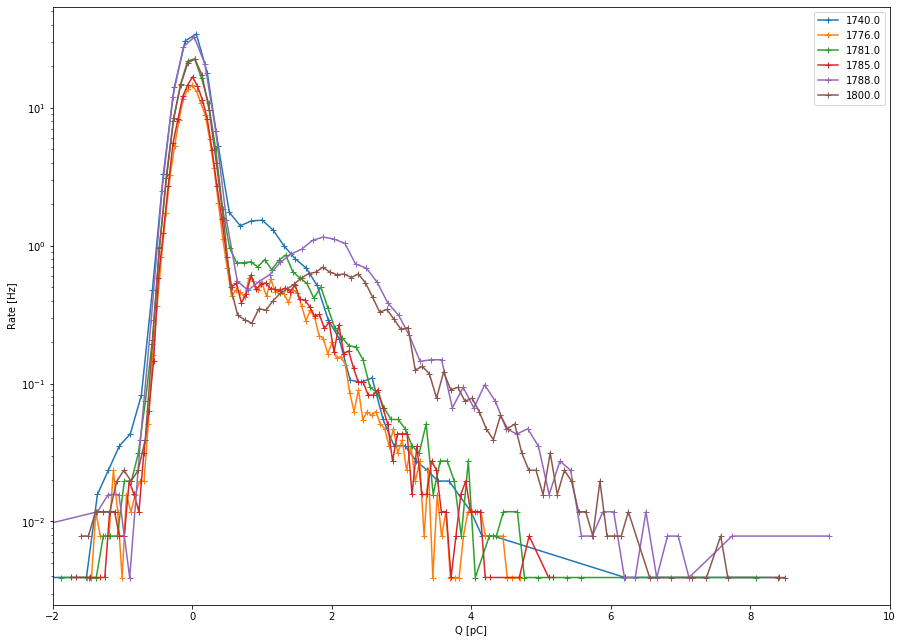

In [3]:
QHists = [tr.extRun(iG,30,3,10,qbins=100,plot=False) for iG in fWaves]
QSPE = np.array([0.]*nGains)
QErr = np.array([0.]*nGains)
for iq in range(nGains):
    #plt.plot(QHists[iq][1],QHists[iq][2],marker='x',label=Gains[iq])
    args = QHists[iq][3]
    lst = 'solid'
    try:
        GFit,GErr = tr.fitQ(QHists[iq],[0,10,1,2,1,1])#,3.2,0.1,1])
        QSPE[iq] = GFit[3]
        print(GFit)
        QErr[iq] = np.sqrt(np.diag(GErr))[3]
    except RuntimeError as e:
        print("Failed to fit {}V Run: {}".format(Gains[iq],e))
        lst = 'dashed'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        #plt.plot(QHists[iq][1],QHists[iq][0],marker='x',label=Gains[iq])
    plt.plot(QHists[iq][1][args],QHists[iq][0][args],marker='+',label=Gains[iq],linestyle=lst)
plt.yscale('log')
plt.xlim(-2,10)
plt.legend()
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')
plt.savefig(pmt+"_GainSPEs.png")

Gains,QSPE/1.6022,QErr

In [4]:
def fit_gain_curve(v, v0, gamma):
    q = ( v / v0 ) ** gamma
    return q
def fit_gain_line(v,v0,gamma):
    q = gamma*v + v0
    return q
qe = 1.6022e-7
from scipy.optimize import curve_fit
fitQ,fitErr = curve_fit(fit_gain_line,Gains,np.log(QSPE/qe),p0=[1,1e3],sigma=QErr/QSPE,absolute_sigma=True)
fitErr = np.sqrt(np.diag(fitErr))
print((fitQ,fitErr,(np.log(1e7)-fitQ[0])/fitQ[1]))
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))
print(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)

(array([-11.28453731,   0.01536107]), array([1.52437190e+00, 8.52719489e-04]), 1783.9008379603317)
0.013547220948270645 -8.278749078906069 0.005633147388055746 1800.8744983950928


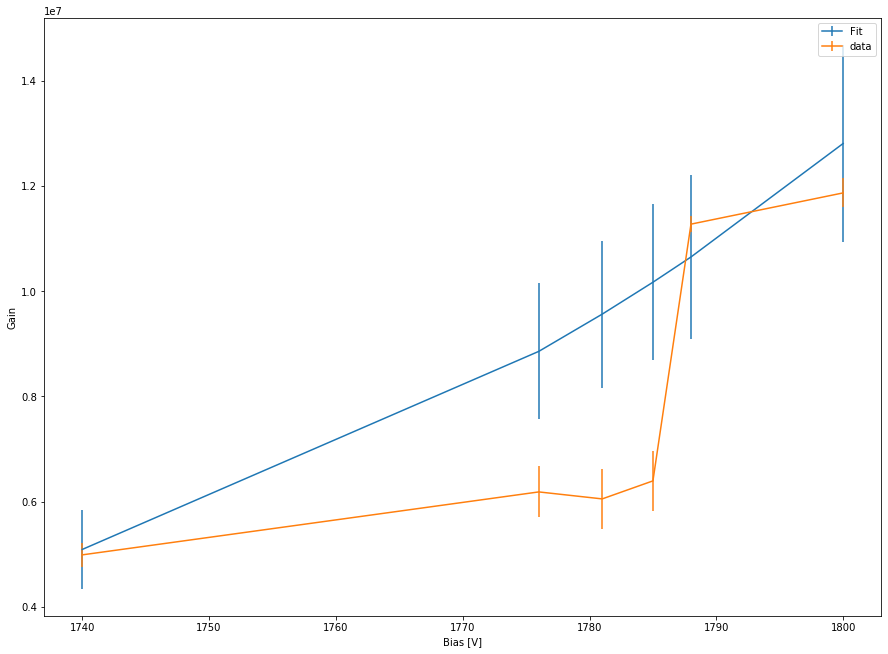

In [5]:
points = np.exp(fitQ[1] * np.array(Gains) + fitQ[0])
pointerr = np.sqrt(np.square(fitErr[1]/fitQ[1])+np.square(fitErr[0]/fitQ[0]))*points
plt.errorbar(Gains,points,yerr=pointerr,label='Fit')
plt.errorbar(Gains,QSPE/qe,label='data',yerr = QErr/qe)
plt.plot()
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.legend()
plt.savefig(pmt+"_GainCurve.png")


## 